In [14]:

import importlib
import experiment
importlib.reload(experiment)
import models
importlib.reload(models)

from experiment import *

In [15]:
exp_name = "GST-D1-HLM_E3-FL"

from pathlib import Path
path = Path("./data/GST-D1-HLM_E3-FL_230105/redoGST-DCP1-HLM_VS_EDC3-FL")
fs = sorted(list(path.glob("*.csv")))

controls_path = Path("./data/GST-D1-HLM_E3-FL_230105/refs")
controls_fs = sorted(list(controls_path.glob("*.csv")))
print(len(fs))
print(len(controls_fs))

20
5


In [16]:
exp = Exp()
exp.load_bli_data(fs)

#remove loading and baselines because you forgot to do that in exp class 
for ds in exp:
    s = ds.steps[0].start
    mask = ds.t >= s
    ds.response = ds.response[mask]
    ds.t = ds.t[mask]
    
# exp.plot()


In [17]:
controls = Exp()
controls.load_bli_data(controls_fs)
controls.interstep_correction()
# controls.plot()


In [18]:
#load descriptions, need to copy from blitz or include it manually
desc = Path(f"./data/GST-D1-HLM_E3-FL_230105/dataset_description.txt")
df = pd.read_csv(desc, sep='\t', index_col=0)
# df

In [19]:
#assign concentrations from desc to each dataset
concs = df['Conc. (uM)'].to_dict()
analyze = df['Analyze'].to_dict()

for ds in exp.datasets:
    idx = ds.name[:-4].split('_')[-1]
    idx=int(idx)
    c = concs[idx]
    if np.isnan(c): c=0
    ds.steps[0].concentration = c*1e-6
    ds.use_for_fit = analyze[idx]



In [20]:
for ds in exp.datasets:
    print(ds)
exp.interstep_correction()
# exp.plot()

Dataset(0, name = 2023-01-05_001.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(1, name = 2023-01-05_002.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(2, name = 2023-01-05_003.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(3, name = 2023-01-05_004.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(4, name = 2023-01-05_005.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(5, name = 2023-01-05_006.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(6, name = 2023-01-05_007.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(7, name = 2023-01-05_008.csv, no_steps = 2, len = 479.79999999999995, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(8, name = 2023-0

In [21]:
#assign conentrations to controls
controls_c = [0.,0.2,0.4,0.8,1.6]
controls_c = [c*1e-6 for c in controls_c]

for ds, c in zip(controls, controls_c):
    ds.steps[0].concentration = c

In [22]:
controls_dict = {}
for ds in controls:
    control_mask = ds.t>=ds.steps[0].start
    c = ds.steps[0].concentration
    controls_dict[c] = ds.response[control_mask]

#subtract controls from ds
for ds in exp:
    if not ds.use_for_fit: continue
    print(ds.steps[0].concentration)
    start = ds.steps[0].start
    mask = ds.t>=start
    r = ds.response[mask]
    c = ds.steps[0].concentration
    if c in controls_dict:
        print('correcting c=',c)
        ds.response[mask] = np.subtract(r, controls_dict[c])
        

# exp.plot()

1.6e-06
correcting c= 1.6e-06
1.6e-06
correcting c= 1.6e-06
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07
8e-07
correcting c= 8e-07
2e-07
correcting c= 2e-07
2e-07
correcting c= 2e-07
1e-07
1e-07
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07


In [23]:
# exp.crop(3)

Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

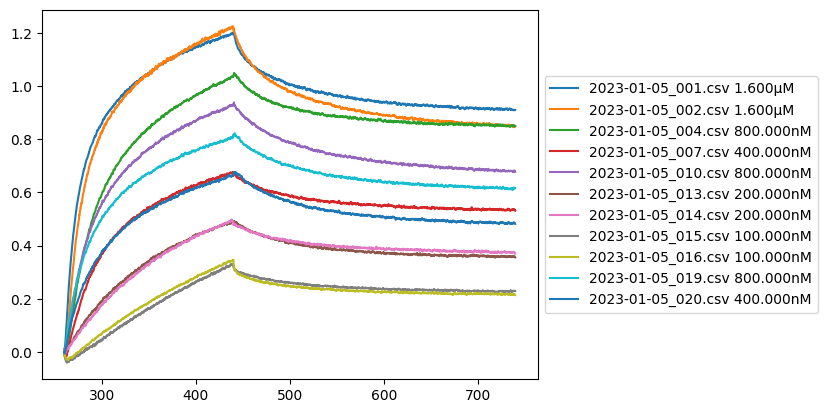

In [24]:
exp.interstep_correction()
exp.plot()

In [25]:
#remove some datasets
ds_to_remove = []#[15, 12, 19, 18, 0, 3]
for ds in exp:
    if ds.use_for_fit == False:
        ds_to_remove.append(ds)
for ds in ds_to_remove:
    exp.datasets.remove(ds)

In [26]:
exp.model = models.Heterogeneous_ligand()
exp.model.params_definitions

{'ka1': <Parameter 'ka1', value=10000.0, bounds=[10.0:10000000.0]>,
 'kd1': <Parameter 'kd1', value=0.01, bounds=[1e-06:0.1]>,
 'ka2': <Parameter 'ka2', value=10000.0, bounds=[10.0:10000000.0]>,
 'kd2': <Parameter 'kd2', value=0.01, bounds=[1e-06:0.1]>,
 'kt': <Parameter 'kt', value=10000000.0, bounds=[10.0:1000000000000.0]>,
 'ymax1': <Parameter 'ymax1', value=1, bounds=[1e-12:10]>,
 'ymax2': <Parameter 'ymax2', value=1, bounds=[1e-12:10]>,
 'offset': <Parameter 'offset', value=0, bounds=[-10:10]>}

In [27]:
# exp.model.params_definitions['ymax'].user_data['type']='global'

# exp.model.params_definitions['ymax1'].user_data['type']='global'
# exp.model.params_definitions['ymax2'].user_data['type']='global'

exp.create_params(offsets=1, mtl = 0)
exp.params


name,value,initial value,min,max,vary
ka1,10000.0000,10000.0,10.0000000,10000000.0,True
kd1,0.01000000,0.01,1.0000e-06,0.10000000,True
ka2,10000.0000,10000.0,10.0000000,10000000.0,True
kd2,0.01000000,0.01,1.0000e-06,0.10000000,True
ymax1_ds0,1.00000000,1,1.0000e-12,10.0000000,True
ymax1_ds1,1.00000000,1,1.0000e-12,10.0000000,True
ymax1_ds3,1.00000000,1,1.0000e-12,10.0000000,True
ymax1_ds6,1.00000000,1,1.0000e-12,10.0000000,True
ymax1_ds9,1.00000000,1,1.0000e-12,10.0000000,True
ymax1_ds12,1.00000000,1,1.0000e-12,10.0000000,True


In [28]:
exp.fit_params()

fitting using: least_squares


'`ftol` termination condition is satisfied.'

(<Figure size 640x480 with 1 Axes>, <Axes: >)

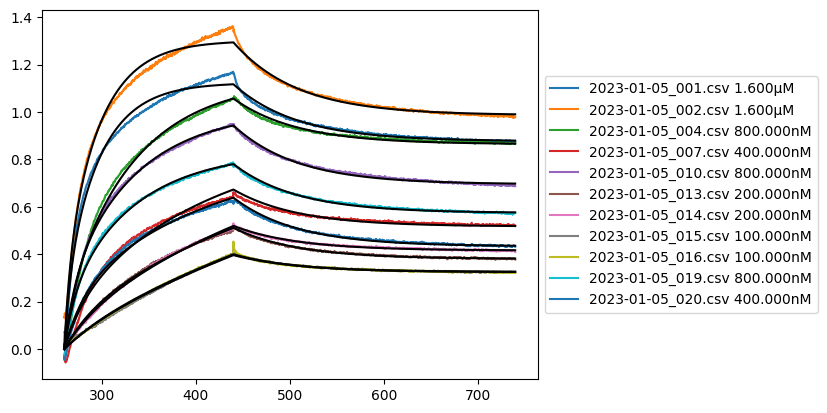

In [29]:
flag = False
for par in exp.params:
    if "offset" in par:
        flag=True

exp.plot(fit=True, correct_offsets=flag)

In [46]:
import plotly.graph_objects as go

fig = go.Figure()

for ds in exp.datasets:
    if ds.use_for_fit == False: continue
    x = np.array([])
    y = np.array([])
    y_fit = np.array([])
    
    for step in ds.steps:
        # if step.concentration>0: color = 'orangered'
        # elif step.concentration==0: color = 'cornflowerBlue'
        # else: color = 'lightgrey'
        mask = (ds.t>=step.start) & (ds.t<step.stop)

        if f"offset_ds{ds.index}_step{step.index}" in exp.params:
                offset = exp.params[f'offset_ds{ds.index}_step{step.index}'].value
        else: 
            offset = 0
        
        x_step = ds.t[mask]
        y_step = ds.response[mask] - offset
        y_fit_step = ds.fit_response[mask] - offset

        x = np.concatenate([x, x_step])
        y = np.concatenate([y, y_step])
        y_fit = np.concatenate([y_fit, y_fit_step])

    
    x = x - x[0]
    fig.add_scatter(x = x, 
                    y = y_fit,
                    marker=dict(size=0, 
                            color='black',
                            line=dict(width=1, color='black')),
                    line=dict(
                         width=2, 
                         color='black'
                         ),
                    name=ds.steps[0].concentration,)

        

    fig.add_scatter(x = x,
                    y = y,
                    marker=dict(
                            size=0, 
                            #color=color, 
                            line=dict(
                                    width=0.1, 
                                    #color=color
                                    )),
                    line=dict(
                            width=1, 
                            #color=color
                            ),
                    name=f"{ds.index}_{ds.steps[0].concentration}",
                    )



fig.update_layout(
            height=600,
            width = 800,
            font_family="Arial",
            font_size = 24,
            showlegend=False,
            margin=dict(l=0,r=0,b=0,t=0,pad=0), 
            template='plotly_white',
            paper_bgcolor="rgb(255, 255, 255)",  
            plot_bgcolor="rgb(255, 255, 255)") 

fig.update_xaxes(
    ticklabelposition="inside top", 
    title='czas [s]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)

fig.update_yaxes(
    ticklabelposition="outside top", 
    title='Sygnał [nm]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)



fig.show()

In [31]:
for ds in exp:
    if ds.index in [15, 12, 19, 18, 0, 3]:
        ds.use_for_fit = False
    if ds.index in [6]:
        ds.use_for_fit = True
    # if ds.steps[0].concentration==16e-6:
    #     ds.use_for_fit = True
[ds.index for ds in exp]



[0, 1, 3, 6, 9, 12, 13, 14, 15, 18, 19]

In [33]:
exp.crop(3)

In [131]:
exp.model.name

'Bivalent analyte'

In [40]:
import kaleido
exp_name = "GST-D1_E3-FL"
fig.write_image(f'{exp_name}-{exp.model.name}.png')

In [41]:

from lmfit.printfuncs import fitreport_html_table
s = fitreport_html_table(exp.result, show_correl=True,  min_correl=0.1)

with open(f"{exp_name}-{exp.model.name}.htm", 'w') as f:
    f.write(s)


In [301]:
from uncertainties import ufloat
def get_html_report(show_correl=True):
    result = exp.result
    tables = result._repr_html_(show_correl=show_correl)
    
    if ('ka' in result.params) and ('kd' in result.params):
        t = []
        cell = lambda x, tag: f'<{tag}> {x} </{tag}>'
        
        has_er = hasattr(result.params['ka'], 'stderr') and (result.params['ka'].stderr is not None)

        if has_er:
            ka = ufloat(float(result.params['ka'].value), float(result.params['ka'].stderr))
            kd = ufloat(float(result.params['kd'].value), float(result.params['kd'].stderr))
            Kd = kd/ka
        else:
            Kd = result.params['kd'].value/result.params['ka'].value

        t.append('<h2>Dissociation constant</h2>')
        t.append('<table><tr>')
        t.append(cell(f"<b>Name</b>", 'td'))
        t.append(cell(f"<b>value</b>", 'td'))
        t.append(cell(f"<b>standard error</b>", 'td'))
        t.append(cell(f"<b>relative error</b>", 'td'))  
        t.append('</tr><tr>')
        t.append(cell(f"<b>Kd</b>", 'td'))
        if has_er:
            t.append(cell(f"{Kd.n:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev/Kd.n:.2%}", 'td'))
        else:
            t.append(cell(f"{Kd:.5e}", 'td'))
            t.append(cell("NA", 'td'))
            t.append(cell("NA", 'td'))
        t.append('</table></tr></table>')

        return tables + ''.join(t)
    
    else: 
        return tables

report = get_html_report(show_correl=False)
with open(f'{exp_name}-{exp.model.name}-extended_report.htm','w') as f:
    f.write(report)

In [124]:
from uncertainties import ufloat

In [125]:
# pars = exp.result.params

# ka1 = pars['ka1'].value
# ka1_er = ka1*25.05/100
# kd1 = pars['kd1'].value
# ka2 = pars['ka2'].value
# kd2 = pars['kd2'].value

# Kd = (kd1 * kd2) / (ka1 * ka2)

In [106]:
exp.model.name

'Heterogeneous ligand'

In [53]:
vals = []
for par in exp.params:
    if 'ymax' in par:
        vals.append(exp.params[par].value)
print(np.average(vals))

1.4331185488596245


In [136]:
exp.model.name

'Bivalent analyte'

In [26]:
3.4615e-04	/0.02554522

2.404034041459876e-06

In [48]:
exp.model.name

'Heterogeneous ligand'

In [42]:
exp.result.params

name,value,standard error,relative error,initial value,min,max,vary
ka1,17064.2221,50.5666661,(0.30%),10000.0,10.0000000,10000000.0,True
kd1,1.0000e-06,7.1512e-06,(715.12%),0.01,1.0000e-06,0.10000000,True
ka2,89474.4314,1490.37795,(1.67%),10000.0,10.0000000,10000000.0,True
kd2,0.01472869,1.4587e-04,(0.99%),0.01,1.0000e-06,0.10000000,True
ymax1_ds0,0.88336057,0.00253185,(0.29%),1,1.0000e-12,10.0000000,True
ymax1_ds1,0.99433749,0.00284347,(0.29%),1,1.0000e-12,10.0000000,True
ymax1_ds3,0.94565478,0.00225461,(0.24%),1,1.0000e-12,10.0000000,True
ymax1_ds6,0.73147163,0.00248744,(0.34%),1,1.0000e-12,10.0000000,True
ymax1_ds9,0.76055761,0.00230450,(0.30%),1,1.0000e-12,10.0000000,True
ymax1_ds12,0.82908910,0.00373565,(0.45%),1,1.0000e-12,10.0000000,True


In [17]:
params = exp.params

y = np.var(np.concatenate([dataset.response for dataset in exp.datasets]).flatten(), ddof=2)
1 - exp.result.redchi / y

0.9985380268941834

In [25]:
exp.model.name

'Bivalent analyte'

In [44]:
exp.result

In [45]:

params = exp.params
y = np.concatenate([dataset.response for dataset in exp.datasets]).flatten()
mask = ~np.isnan(y)
y=y[mask]
y = np.var(y, ddof=2)

1 - exp.result.redchi / y

0.9985067554257356